<a href="https://colab.research.google.com/github/siddhantjain07/DeepLearning/blob/master/BatchSeqModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

device_gpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
from IPython.display import clear_output

#Dataset

##Pre-Processing

In [6]:
languages = []
data = []
X = []
y = []

with open('name2lang.txt', 'r') as f:
  for line in f:
    line = line.split(',')
    name = line[0].strip()
    lang = line[1].strip()
    if not lang in languages:
      languages.append(lang)
    X.append(name)
    y.append(lang)
    data.append((name, lang))

n_languages = len(languages)

In [7]:
print(n_languages)

18


In [8]:
print(languages)

['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']


In [9]:
print(data[0:10])

[('Abreu', 'Portuguese'), ('Albuquerque', 'Portuguese'), ('Almeida', 'Portuguese'), ('Alves', 'Portuguese'), ('Araujo', 'Portuguese'), ('Araullo', 'Portuguese'), ('Barros', 'Portuguese'), ('Basurto', 'Portuguese'), ('Belo', 'Portuguese'), ('Cabral', 'Portuguese')]


##Train test split

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print(len(X_train), len(X_test))

16040 4010


##Encoding names and languages

In [13]:
all_letters = string.ascii_letters + " .,;'"
n_letters  = len(all_letters)
print(n_letters)

57


In [14]:
def name_rep(name):
  rep = torch.zeros(len(name), 1, n_letters)
  for index, letter in enumerate(name):
    pos = all_letters.find(letter)
    rep[index][0][pos] = 1

  return rep

In [19]:
def lang_rep(lang):
  return torch.tensor([languages.index(lang)], dtype=torch.long)

In [17]:
name_rep('Abreu')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [20]:
lang_rep('Greek')

tensor([5])

#Basic Network and testing inference

In [21]:
class RNN_net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN_net, self).__init__()
    self.hidden_size = hidden_size
    self.rnn_cell = nn.RNN(input_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input_, hidden = None, batch_size = 1):
    out, hidden = self.rnn_cell(input_, hidden)
    output = self.h2o(hidden.view(-1, self.hidden_size))
    output = self.softmax(output)
    return output, hidden

  def init_hidden(self, batch_size = 1):
    return torch.zeros(1, batch_size, self.hidden_size)

In [22]:
n_hidden = 128
net = RNN_net(n_letters, n_hidden, n_languages)

In [23]:
def infer(net, name, device = 'cpu'):
  name_ohe = name_rep(name).to(device)
  output, hidden = net(name_ohe)
  if type(hidden) is tuple:
    hidden = hidden[0]
  index = torch.argmax(hidden)
  return output

In [24]:
infer(net, 'Adam')

tensor([[-2.8059, -2.8097, -2.8903, -3.0745, -2.8038, -2.9613, -2.8060, -2.9334,
         -2.8371, -2.8294, -2.9614, -3.0113, -2.8369, -2.9247, -2.9541, -2.9577,
         -2.8116, -2.8740]], grad_fn=<LogSoftmaxBackward>)

##Evaluate Model

In [27]:
def dataloader(npoints, X_, y_):
  to_ret = []
  for i in range(npoints):
    index_ = np.random.randint(len(X_))
    name, lang = X_[index_], y_[index_]
    to_ret.append((name, lang, name_rep(name), lang_rep(lang)))
  return to_ret

In [28]:
dataloader(2, X_train, Y_train)

[('Rekunov',
  'Russian',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,

In [29]:
def eval(net, n_points, topk, X_, y_, device='cpu'):
  net = net.eval().to(device)
  data_ = dataloader(n_points, X_, y_)
  correct = 0

  for name, language, name_ohe, lang_rep in data_:
    output = infer(net, name, device)
    val, indices = output.topk(topk)
    indices = indices.to('cpu')
    if lang_rep in indices:
      correct += 1 
  accuracy = correct/n_points
  return accuracy

In [31]:
eval(net, 1000, 1,X_test, Y_test)

0.018

##Batching

In [33]:
def batched_name_rep(names, max_word_size):
  rep = torch.zeros(max_word_size, len(names), n_letters)
  for name_index, name in enumerate(names):
    for letter_index, letter in enumerate(name):
      pos = all_letters.find(letter)
      rep[letter_index][name_index][pos] = 1
  return rep

In [34]:
def print_char(name_reps):
  name_reps = name_reps.view((-1, name_reps.size()[-1]))
  for t in name_reps: 
    if torch.sum(t) == 0:
      print('<pad>')
    else:
      index = t.argmax()
      print(all_letters[index])

In [35]:
out_ = batched_name_rep(['Shyam', 'Ram'], 5)
print(out_)
print(out_.shape)
print_char(out_)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0

In [36]:
def batched_lang_rep(langs):
    rep = torch.zeros([len(langs)], dtype=torch.long)
    for index, lang in enumerate(langs):
        rep[index] = languages.index(lang)
    return rep

In [37]:
def batched_dataloader(npoints, X_, y_, verbose=False, device = 'cpu'):
    names = []
    langs = []
    X_lengths = []
    
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        X_lengths.append(len(name))
        names.append(name)
        langs.append(lang)
    max_length = max(X_lengths)
    
    names_rep = batched_name_rep(names, max_length).to(device)
    langs_rep = batched_lang_rep(langs).to(device)
    
    padded_names_rep = torch.nn.utils.rnn.pack_padded_sequence(names_rep, X_lengths, enforce_sorted = False)
    
    if verbose:
        print(names_rep.shape, padded_names_rep.data.shape)
        print('--')
    
    if verbose:
        print(names)
        print_char(names_rep)
        print('--')
    
    if verbose:
        print_char(padded_names_rep.data)
        print('Lang Rep', langs_rep.data)
        print('Batch sizes', padded_names_rep.batch_sizes)
    
    
    return padded_names_rep.to(device), langs_rep

In [39]:
p, l = batched_dataloader(3, X_train, Y_train, True)

torch.Size([12, 3, 57]) torch.Size([22, 57])
--
['Pini', 'Nujdin', 'Rjeshotarsky']
P
N
R
i
u
j
n
j
e
i
d
s
<pad>
i
h
<pad>
n
o
<pad>
<pad>
t
<pad>
<pad>
a
<pad>
<pad>
r
<pad>
<pad>
s
<pad>
<pad>
k
<pad>
<pad>
y
--
R
N
P
j
u
i
e
j
n
s
d
i
h
i
o
n
t
a
r
s
k
y
Lang Rep tensor([17, 13, 13])
Batch sizes tensor([3, 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 1])


#Training

##Basic Setup

In [44]:
def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, Y_train)
    
    total_loss = 0
    
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i:i+1], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
    return total_loss/n_points

In [45]:
def train_batch(net, opt, criterion, n_points, device = 'cpu'):
    
    net.train().to(device)
    opt.zero_grad()
    
    batch_input, batch_groundtruth = batched_dataloader(n_points, X_train, Y_train, False, device)
    
    output, hidden = net(batch_input)
    
    loss = criterion(output, batch_groundtruth)
    
    loss.backward()
    opt.step()
    return loss

In [46]:
net = RNN_net(n_letters, n_hidden, n_languages)
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [47]:
%%time 
train(net, opt, criterion, 256)

CPU times: user 712 ms, sys: 16 ms, total: 728 ms
Wall time: 734 ms


tensor(2.8666, grad_fn=<DivBackward0>)

In [48]:
net = RNN_net(n_letters, n_hidden, n_languages)
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [49]:
%%time 
train_batch(net, opt, criterion, 256)

CPU times: user 39.9 ms, sys: 5.08 ms, total: 45 ms
Wall time: 78.9 ms


tensor(2.8912, grad_fn=<NllLossBackward>)

##FUll train setup

In [53]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    net = net.to(device)
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            # print('Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test))
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    print('Top-1:', eval(net, len(X_test), 1, X_test, Y_test, device), 'Top-2:', eval(net, len(X_test), 2, X_test, Y_test, device))
                      

##RNN Cell

Iteration 4999 Loss 0.4640139043331146


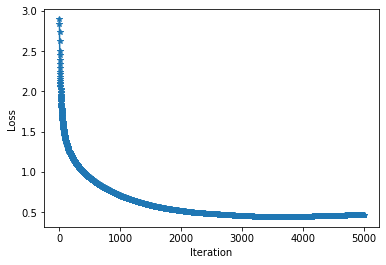




Top-1: 0.756857855361596 Top-2: 0.8581047381546134
CPU times: user 5min 12s, sys: 3.46 s, total: 5min 15s
Wall time: 5min 15s


In [54]:
%%time
net = RNN_net(n_letters, 128, n_languages)
train_setup(net, lr=0.15, n_batches=5000, batch_size = 512, display_freq=500) # CPU Training example

Iteration 4999 Loss 0.4354103207588196


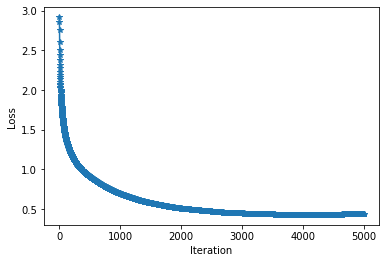




Top-1: 0.7463840399002494 Top-2: 0.8561097256857856
CPU times: user 3min 31s, sys: 6.06 s, total: 3min 38s
Wall time: 3min 44s


In [55]:
%%time
net = RNN_net(n_letters, 128, n_languages)
train_setup(net, lr=0.15, n_batches=5000, batch_size = 512, display_freq=100, device = device_gpu) # GPU Training Example

##LSTM Cell

In [56]:
class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_net, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTM(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden = None):
        out, hidden = self.lstm_cell(input, hidden)
        output = self.h2o(hidden[0].view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self, batch_size = 1):
        return (torch.zeros(1, batch_size, self.hidden_size), torch.zeros(1, batch_size, self.hidden_size))

Iteration 7999 Loss 0.24692653119564056


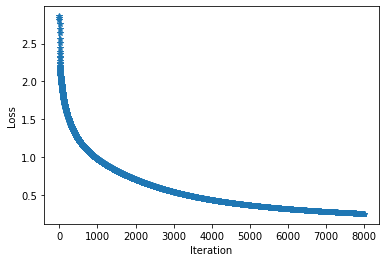




Top-1: 0.7992518703241895 Top-2: 0.8817955112219451


In [57]:
n_hidden = 128
net = LSTM_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.15, n_batches=8000, batch_size = 512, display_freq=1000, device = device_gpu)

##GRU Cell

In [58]:
class GRU_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_net, self).__init__()
        self.hidden_size = hidden_size
        self.gru_cell = nn.GRU(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden = None):
        out, hidden = self.gru_cell(input, hidden)
        output = self.h2o(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden

Iteration 7999 Loss 0.22101762890815735


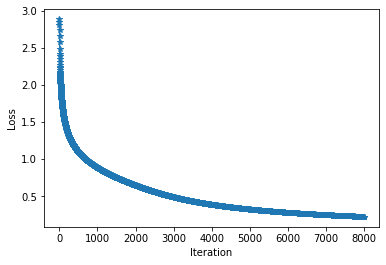




Top-1: 0.8129675810473815 Top-2: 0.8912718204488778


In [59]:
n_hidden = 128
net = GRU_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.15, n_batches=8000, batch_size = 512, display_freq=1000, device = device_gpu)